In [1]:
!pip install ginza==3.1.2
#!git clone https://github.com/amueller/word_cloud
#!cd word_cloud && python setup.py install
!pip install scattertext jieba empath astropy gensim umap-learn
!apt install fonts-takao-pgothic

     |████████████████████████████████| 54.9MB 93kB/s 
     |████████████████████████████████| 44.8MB 231kB/s 
  Created wheel for ginza: filename=ginza-3.1.2-cp37-none-any.whl size=17312 sha256=f1abefc4898675ae3c9ca281ae535d74172b0d0defbaff860f6b49ef037c2ab4
  Stored in directory: /root/.cache/pip/wheels/70/8d/57/f089078acc0dbaebffc08c178e9f20924fa794c114ad36f7f7
  Created wheel for ja-ginza: filename=ja_ginza-3.1.0-cp37-none-any.whl size=54963620 sha256=bda480599076a6851f90e1bba87e194788583ec5fd33e845a05979edef7a38f2
  Stored in directory: /root/.cache/pip/wheels/f2/8a/07/1837eeb5c5648fa8d266102b78a894e495234585ac3f024cf1
  Created wheel for ja-ginza-dict: filename=ja_ginza_dict-3.1.0-cp37-none-any.whl size=70877544 sha256=e3b045745e966f4068ec47a9caf5522a674c5b81d9fe505832f6950c6e6e0b0f
  Stored in directory: /root/.cache/pip/wheels/30/88/d7/7f0692ba26060966af34538e1079438d16640c54e04a15a76a
Successfully built ginza ja-ginza ja-ginza-dict
  Found existing installation: ja-ginza 4.0.0

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [39]:
import os
import numpy as np

LDCC_DIR = "/content/drive/My Drive/Colab Notebooks/data_analyze/text"

groups = []
groups.append('fukushima')
groups.append('heavy_rain')
groups.append('typhoon')
#groups.append('Pred1.5--Ans1')

texts  = []
labels = []

import pandas as pd
data = pd.read_excel(LDCC_DIR + '/台風豪雨福島.xlsx')
#data = pd.read_excel(LDCC_DIR + '/予測2実際0.xlsx')

with open(LDCC_DIR + '/fukushima.txt', 'w') as f1, open(LDCC_DIR + '/heavy_rain.txt', 'w') as f2, open(LDCC_DIR + '/typhoon.txt', 'w') as f3:
   cnt1 = cnt2 = cnt3 = 0
   for text, detail, type in zip(data['Text'], data['detail'], data['type']):
     if detail == 's':
       if type == 'f':
         f1.write(text)
         cnt1 += 1
       elif type == 'g':
         f2.write(text)
         cnt2 += 1
       elif type == 't':
         f3.write(text)
         cnt3 += 1
print(cnt1, cnt2, cnt3)

#groups.remove('fukushima')
#groups.remove('heavy_rain')
#groups.remove('typhoon')

for group in groups:
  with open(LDCC_DIR + '/' + group + '.txt', 'r') as f:
    lines = f.readlines()
    text = "".join(lines[:])
  texts.append(text)
  labels.append(group)
#labels.append('Pred1.5--Ans1')

labels = np.array(labels) 
print(labels)

# lines = data.Text.values.tolist()
# text = "".join(lines[:])
# texts.append(text)

239 155 179
['fukushima' 'heavy_rain' 'typhoon']


In [38]:
#1次 or その他

import os
import numpy as np

LDCC_DIR = "/content/drive/My Drive/Colab Notebooks/data_analyze/text"

groups = []
groups.append('primary')
groups.append('else')

texts  = []
labels = []

import pandas as pd
data = pd.read_excel(LDCC_DIR + '/台風豪雨福島.xlsx')

with open(LDCC_DIR + '/primary.txt', 'w') as f1, open(LDCC_DIR + '/else.txt', 'w') as f2:
  cnt1 = cnt2 = 0
  for text, label, detail, type in zip(data['Text'], data['label'], data['detail'], data['type']):
    if type == 't':
      if label == 0:
        f1.write(text)
        cnt1 += 1
      elif detail == 's':
        f2.write(text)
        cnt2 += 1
print(cnt1, cnt2)

for group in groups:
  with open(LDCC_DIR + '/' + group + '.txt', 'r') as f:
    lines = f.readlines()
    text = "".join(lines[:])
  texts.append(text)
  labels.append(group)

labels = np.array(labels) 
print(labels)

0 0
['primary' 'else']


In [40]:
import pkg_resources, imp
imp.reload(pkg_resources)

import spacy
nlp = spacy.load('ja_ginza')
docs = list(nlp.pipe(texts, disable=['ner']))

/usr/local/lib/python3.7/dist-packages/spacy/util.py:275: UserWarning: [W031] Model 'ja_ginza' (3.1.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [41]:
for doc in docs:
  with doc.retokenize() as retokenizer:
    for noun_chunk in doc.noun_chunks:
      retokenizer.merge(noun_chunk)

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
NGRAM=1
MAX_DF=0.95
MIN_DF=0.03
NUM_VOCAB=1000

In [43]:
import ginza
stop_words = list(ginza.STOP_WORDS)
stop_words.extend(['豪雨','台風','御嶽山','選挙','10','url'])
#stop_words= list(['豪雨','台風','御嶽山','選挙','台風9号','台風10号','10号','url','_url_'])

In [44]:
def soften(word):
  replace_table = {
      '為る': 'する', '成る': 'なる', '遣る': 'やる', '有る': 'ある', '無い': 'ない',
      '御洒落': 'おしゃれ', '撫子': 'なでしこ', '未だ未だ': 'まだまだ', '迚も': 'とても',
      '唯': 'ただ', '筈': 'はず', '若し': 'もし'
  }
  return replace_table.get(word, word)

In [45]:
POS = ['VERB', 'NOUN', 'ADJ', 'ADV', 'PROPN'] #   VERB:動詞    NOUN:名詞   ADJ:形容詞    ADV:副詞    PROPN:固有名詞
tokens = []
with open(LDCC_DIR + '/lemmatize1.txt', 'w') as f1, open(LDCC_DIR + '/lemmatize2.txt', 'w') as f2, open(LDCC_DIR + '/lemmatize3.txt', 'w') as f3:
  for doc in docs:
    tokens.append(" ".join([token.lemma_ for token in doc if token.pos_  in POS or len(POS) ==0]))

  f1.write(" ".join([token.lemma_ for token in docs[0]]))
  f1.write('\n')
  f2.write(" ".join([token.lemma_ for token in docs[1]]))
  f2.write('\n')
  # f3.write(" ".join([token.lemma_ for token in docs[2]]))
  # f3.write('\n')

cv = CountVectorizer(stop_words=stop_words, ngram_range=(NGRAM,NGRAM),  max_features=NUM_VOCAB)
X_bow = cv.fit_transform(tokens).toarray()
print("Shape of X : %s" % (X_bow.shape,))

Shape of X : (3, 1000)


In [46]:
vocab  = cv.vocabulary_ 
print("Sample of vocab : %s" % (list(vocab.keys())[:3]))
print()

a = X_bow[np.nonzero(X_bow)]
ave = np.average(a)
sd = np.std(a)
per = np.percentile(a, q=[0,25,50,75,99,100])
print("平均値:",ave)
print("標準偏差:",sd)
print("四分位範囲:",per)

Sample of vocab : ['一番', '分かる', '噴火']

平均値: 2.362914862914863
標準偏差: 4.621180129500307
四分位範囲: [  1.     1.     1.     2.    16.15 127.  ]


In [47]:
TOP_K = 20
sum_all = np.sum(X_bow, axis=0)
indices_topk = np.argsort(sum_all)[::-1][:TOP_K]
X_bow_topk = np.take(X_bow, indices_topk, axis=1)
print("Shape of X : %s" % (X_bow_topk.shape,))

reverse_vocab = {vocab[k]:k for k in vocab.keys()}
words = [reverse_vocab[i] for i in indices_topk]

Shape of X : (3, 20)


In [48]:
group_wordcount = {}
for group in groups:
    indices = np.where(labels == group)[0]
    X_group = np.take(X_bow_topk, indices, axis=0)
    sum_group = np.sum(X_group, axis=0) 
    group_wordcount[group] = sum_group

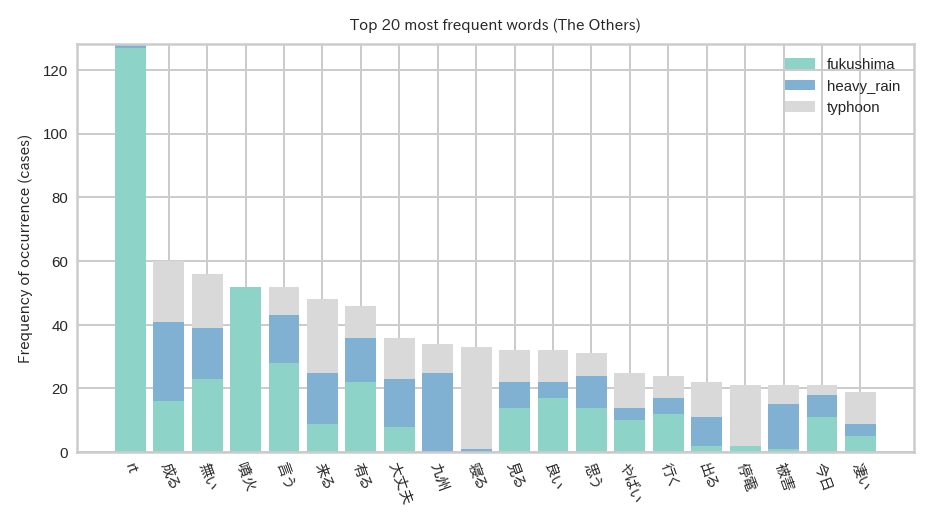

In [49]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties
%matplotlib inline
plt.style.use('seaborn-whitegrid')

def plot_word_dist(words, group_wordcount, title, color="darkcyan"):
    left = np.array(list(range(len(words))))
    f, ax = plt.subplots(figsize=(6,3), dpi=180)
    fp = FontProperties(fname='/usr/share/fonts/truetype/fonts-japanese-gothic.ttf', size=6)
    bottom = np.zeros(len(words))
    cmap = cm.get_cmap('Set3')
    for i, group in enumerate(group_wordcount.keys()):
        vector = group_wordcount[group]
        color=1/len(groups) * i
        plt.bar(left, vector, label=group, bottom=bottom, color=cmap(color))
        bottom += vector
    ax.legend(loc='upper right')
    plt.xticks(left, words, rotation=290,  fontproperties=fp)
    plt.ylabel("Frequency of occurrence (cases)", fontproperties=fp)
    plt.title(title, fontproperties=fp)
    plt.tick_params(labelsize=6)
    plt.legend(fontsize=6)

plot_word_dist(words, group_wordcount, "Top 20 most frequent words (The Others)")

In [ ]:
POS = ['NOUN', 'VERB', 'ADJ', 'ADV']
tokens = []
for doc in docs:
    tokens.append(" ".join([token.lemma_ for token in doc if token.pos_ in POS or len(POS) ==0]))
cv = CountVectorizer(stop_words=stop_words, ngram_range=(1,NGRAM), max_df=MAX_DF, min_df=MIN_DF, max_features=NUM_VOCAB)
X_bow = cv.fit_transform(tokens).toarray()
print("Shape of X : %s" % (X_bow.shape,))
#Shape of X : (7376, 766)
vocab  = cv.vocabulary_

Shape of X : (2, 1000)


In [ ]:
X_sum = np.sum(X_bow, axis=0)
total_occurence_rate = X_sum / len(X_bow)

In [ ]:
group = "primary"
indices = np.where(labels == group)[0]
count = len(indices)
X_group = np.take(X_bow, indices, axis=0)
group_sum = np.sum(X_group, axis=0)
group_occurence_rate = group_sum / count

In [ ]:
sub = group_occurence_rate - total_occurence_rate
div = group_occurence_rate / total_occurence_rate
jlh = sub * div

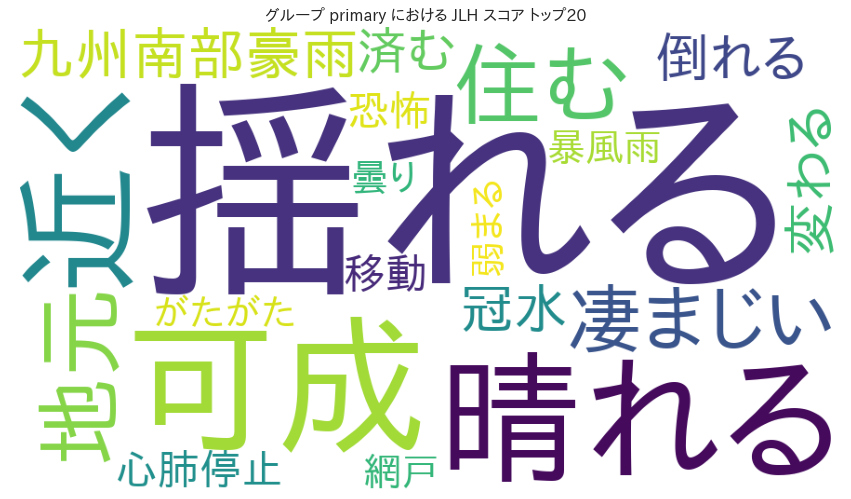

In [ ]:
from wordcloud import WordCloud
def plot_wordcloud(vocab, jlh_indices_topk, jlh_score_topk, group):
  reverse_vocab = {vocab[k]:k for k in vocab.keys() }
  words_topk = [soften(reverse_vocab[i]) for i in jlh_indices_topk]

  word_freq = {}
  for i, word in enumerate(words_topk):
    word_freq[word] = jlh_score_topk[i]

  fpath = '/usr/share/fonts/truetype/fonts-japanese-gothic.ttf'
  fp = FontProperties(fname=fpath, size=16)
  wordcloud = WordCloud(background_color="white",font_path=fpath, width=900, height=500)
  image = wordcloud.generate_from_frequencies(word_freq)
  plt.figure(figsize=(15,12))
  plt.imshow(image)
  plt.axis("off")
  plt.title("グループ %s における JLH スコア トップ20" % group, fontproperties=fp)
  plt.show()

TOP_K_JLH = 20
jlh_indices_topk = np.argsort(jlh)[::-1][:TOP_K_JLH]
jlh_topk = np.take(jlh, jlh_indices_topk)
plot_wordcloud(vocab, jlh_indices_topk, jlh_topk, group)

In [ ]:
import pandas as pd
import scattertext as st
ldcc_df = pd.DataFrame([[example[0], example[1]] for example in zip(labels,docs) 
    if example[0] in ["primary", "else"]])
ldcc_df.columns = ["group", "text"]

In [ ]:
print(ldcc_df.head(3))

     group                                               text
0  primary  (川内原発再稼働, を, 考える, 片山さつき参院議員, の, デマツイート投稿, に, 抗...
1     else  (一番, わから, なかっ, た, の, は, 噴火, の, 規模 ゲリラ豪雨, 、, スー...


In [ ]:
from collections import Counter
from itertools import chain

class PosFilteredUnigramFeatsFromSpacyDoc(object):
    def __init__(self,
                 use_lemmas=False,
                 strip_final_period=False,
               poses_to_include = ['VERB','NOUN','ADJ','ADV']):
        self._use_lemmas = use_lemmas
        self._strip_final_period = strip_final_period
        self._poses_to_include = poses_to_include

    def _post_process_term(self, term):
        if self._strip_final_period and (term.strip().endswith('.') or term.strip().endswith(',')):
            term = term.strip()[:-1]
        return term

    def get_doc_metadata(self, doc):
        return Counter()

    def get_feats(self, doc):
        ngram_counter = Counter()
        for sent in doc.sents:
            unigrams = self._get_unigram_feats(sent)
            ngram_counter += Counter(chain(unigrams, []))
        return ngram_counter

    def _get_unigram_feats(self, sent):
        unigrams = []
        for tok in sent:
            if tok.pos_ in self._poses_to_include:
                if self._use_lemmas and tok.lemma_.strip():
                    unigrams.append(self._post_process_term(soften(tok.lemma_.strip())))
                elif tok.lower_.strip():
                    unigrams.append(self._post_process_term(tok.lower_.strip()))
        return unigrams

    def has_metadata_term_list(self):
        return False

    def get_top_model_term_lists(self):
        raise Exception("No topic models associated with these features.")

In [ ]:
import scattertext as st
from scattertext.features import FeatsFromSpacyDoc
feats_from_spacy_doc=PosFilteredUnigramFeatsFromSpacyDoc(use_lemmas=True)
#feats_from_spacy_doc=FeatsFromSpacyDoc() # こちらは scattertext のデフォルト実装
corpus = st.CorpusFromParsedDocuments(ldcc_df, category_col="group", parsed_col="text", 
                                      feats_from_spacy_doc=feats_from_spacy_doc).build()

In [ ]:
html = st.produce_scattertext_explorer(corpus, category='primary',
          category_name='1次情報', not_category_name='その他',
          width_in_pixels=1000, minimum_term_frequency=7, max_terms=4000)

In [ ]:
from IPython.display import HTML
HTML(html)

In [ ]:
open("/content/drive/My Drive/Colab Notebooks/term_scatter_plot.html", 'wb').write(html.encode('utf-8')) 

1050170

In [ ]:
tokens = []
labels_sent = []
for i, doc in enumerate(docs):
    for sent in doc.sents:
        tokens_of_sent = [token.lemma_ for token in sent if token.pos_ in POS or len(POS) ==0]
        if len(tokens_of_sent) < 2:
            continue
        tokens.append(" ".join(tokens_of_sent))
        labels_sent.append(labels[i])
labels_sent = np.array(labels_sent)

In [ ]:
def calc_cooccurrence(bow):
    length = bow.shape[0]
    clear_diag = np.ones(length, dtype=np.int) - np.eye(length, dtype=np.int)
    array = np.minimum.outer(bow, bow) * clear_diag
    return (array > 0).astype(int)

In [ ]:
group = "sesquiary"
indices = np.where(labels_sent == group)[0]
tokens_group = np.take(tokens, indices, axis=0)
cv_group = CountVectorizer(stop_words=stop_words, ngram_range=(1,NGRAM), min_df=len(indices) // 100, max_features=NUM_VOCAB) 
X_bow_group = cv_group.fit_transform(tokens_group).toarray()
vocab_group  = cv_group.vocabulary_ 
vocab_size = X_bow_group.shape[1]
intersection = np.zeros([vocab_size, vocab_size]).astype(int)
for bow in X_bow_group:
    intersection += calc_cooccurrence(bow)
sum_occurrences = np.sum((X_bow_group > 0).astype(int), axis=0)
union = np.add.outer(sum_occurrences, sum_occurrences) - intersection
union[np.where(union==0)[0]] = 1 # to avoid division by zero.
jaccards = intersection / union

In [ ]:
import networkx as nx
from itertools import combinations
def create_graph(scores, vocab, topk=50):
    vocab = {soften(word):id for word,id in vocab.items()}
    G = nx.Graph()
    G.add_nodes_from([w for w in vocab.keys()])

    flatten_scores = scores.reshape([-1])
    # "*2" は scores は同じ値が対角線両側の二回ずつ入る為
    thresh = np.sort(flatten_scores)[::-1][topk*2] 

    reverse_vocab = {vocab[k]:k for k in vocab.keys() }

    # Top K 以上の score(Jaccard係数) の単語ペアにエッジを張る
    for (i,j) in combinations(range(scores.shape[0]), 2):
        weight = scores[i][j]
        if weight > thresh:
            G.add_edge(reverse_vocab[i], reverse_vocab[j], weight=weight)

    # エッジが張られていない頂点を削除
    isolated = [n for n in G.nodes if len([i for i in nx.all_neighbors(G, n)]) == 0]
    for n in isolated:
       G.remove_node(n)
    return G

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
%matplotlib inline

def plot_network(group, G, k=None, iterations=50, fontsize=12, node_size_factor=30000, edge_width_factor=20):
    fp = FontProperties(fname='/usr/share/fonts/truetype/fonts-japanese-gothic.ttf', size=fontsize)
    plt.figure(figsize=(12, 8))

    layout = nx.spring_layout(G, k=k, iterations=iterations)  

    pr = nx.pagerank(G)
    pr_values = np.array([pr[node] for node in G.nodes()])

    connecteds = []
    colors = []
    for i, c in enumerate(nx.connected_components(G)):
      connecteds.append(c)
      colors.append(1/18 * i)

    node_colors = []
    for node in G.nodes():
      for i, c in enumerate(connecteds):
        if node in c:
          node_colors.append(colors[i])
          break

    nx.draw_networkx_nodes(G, layout, node_color=node_colors, cmap=plt.cm.get_cmap('Set3'), 
        alpha=0.7, node_size=pr_values * node_size_factor)

    labels = nx.draw_networkx_labels(G, layout)
    for t in labels.values():
        t.set_fontproperties(fp)

    edge_width = [d["weight"] * edge_width_factor for (u, v, d) in G.edges(data=True)]
    nx.draw_networkx_edges(G, layout, alpha=0.4, edge_color="darkgrey", width=edge_width)
    plt.title("単語共起ネットワーク(1.5次情報)", fontproperties=fp)
    plt.axis('off')

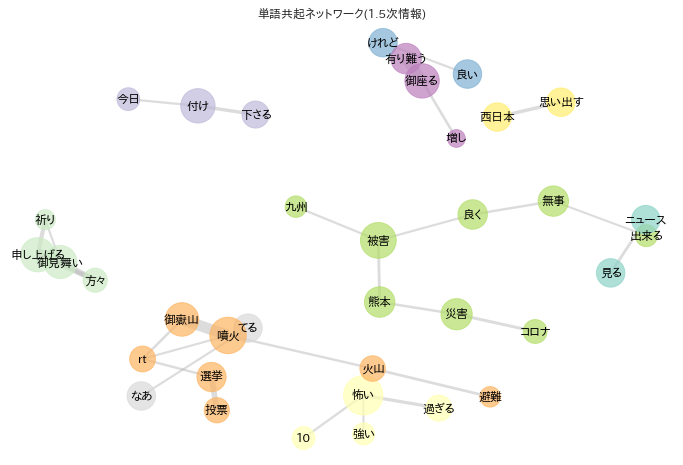

In [ ]:
import math
G = create_graph(jaccards, vocab_group, topk=30)
k = 2.0/math.sqrt(len(G.nodes()))
plot_network(group, G, k=k, iterations=65)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tokens = []
for doc in docs:
    tokens.append(" ".join([token.lemma_ for token in doc if token.pos_ in POS or len(POS) ==0]))
tv = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,NGRAM), max_df=MAX_DF, min_df=MIN_DF, max_features=NUM_VOCAB)
X_tfidf = tv.fit_transform(tokens)
vocab = tv.vocabulary_
reverse_vocab = { vocab[k]:k for k in vocab.keys() }
vocab_size = len(vocab)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
lda = LDA(n_components=3, max_iter=30, n_jobs=-1, verbose=1, evaluate_every=1)
lda.fit(X_tfidf)

iteration: 1 of max_iter: 30, perplexity: 7375.0855
iteration: 2 of max_iter: 30, perplexity: 7182.4047
iteration: 3 of max_iter: 30, perplexity: 7182.3917


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=30,
                          mean_change_tol=0.001, n_components=3, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=1)

In [ ]:
def calc_cooccurrence(bow):
    length = bow.shape[0]
    clear_diag = np.ones(length, dtype=np.int) - np.eye(length, dtype=np.int)
    array = np.minimum.outer(bow, bow) * clear_diag
    return (array > 0).astype(int)

import math
def calc_umass_coherence(v_t, d_vl, d_vm_vl, as_mean=False):
    sum_of_word_pairs = 0.0
    num_of_word_pair = 0
    for m in range(1, len(v_t)):
        for l in range(m):
            sum_of_word_pairs += math.log((d_vm_vl[v_t[m]][v_t[l]] + 1.0) / d_vl[v_t[l]])
            num_of_word_pair +=1
    if as_mean:
      return sum_of_word_pairs / num_of_word_pair
    else:
      return sum_of_word_pairs

In [ ]:
n_components = 3
X = X_tfidf.toarray()
d_vm_vl = np.zeros([vocab_size, vocab_size]).astype(int)
for bow in X:
  d_vm_vl += calc_cooccurrence(bow)
d_vl = np.sum((X > 0).astype(int), axis=0)
sum_coherences = 0.0
for i, component in enumerate(lda.components_):
  top_k_indices = component.argsort()[::-1][:10]
  sum_coherences += calc_umass_coherence(top_k_indices, d_vl=d_vl, d_vm_vl=d_vm_vl)
u_mass = sum_coherences / n_components
u_mass

12.730283365896254

In [ ]:
top_k_words = []
for i, component in enumerate(lda.components_):
    top_k_indices = component.argsort()[::-1][:10]
    top_k_word = {soften(reverse_vocab[k]): component[k] for k in top_k_indices}
    top_k_words.append(top_k_word)

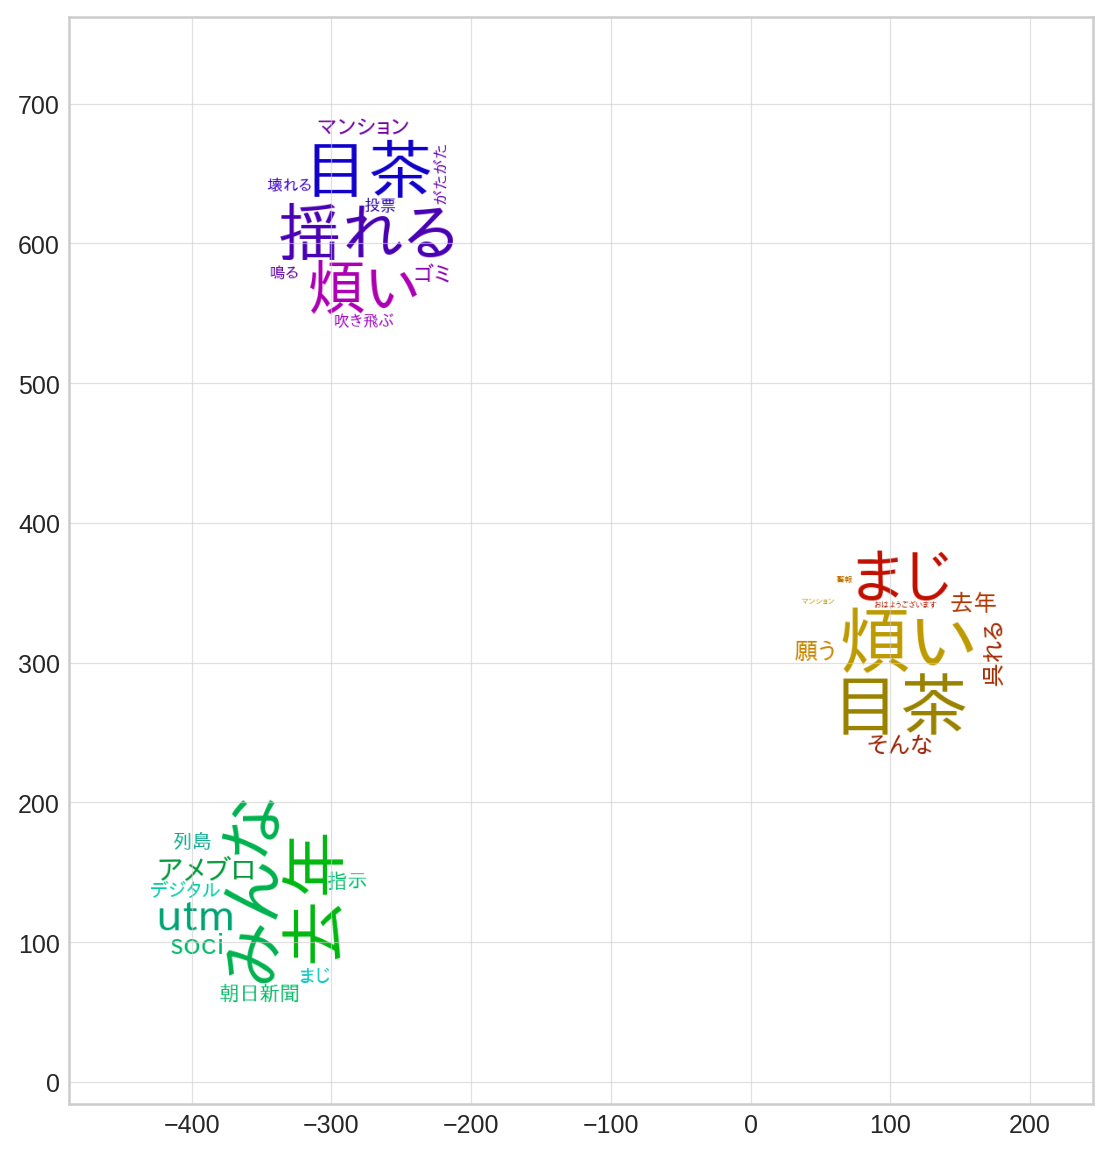

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties
%matplotlib inline
plt.style.use('seaborn-whitegrid')
from sklearn.manifold import TSNE
from wordcloud import WordCloud
import random
from functools import partial

def topic_cloud(word_freqs, hue_index, size=300):  

  def circle(size=300):
    d = size
    r = size // 2
    m = r * 0.86
    x, y = np.ogrid[:d, :d]
    mask = (x - r) ** 2 + (y - r) ** 2 > m ** 2
    return 255 * mask.astype(int)

  def random_color_func(word, font_size, position, orientation, 
                        random_state=None, num_topics=9, hue_index=0, **kwargs):
    fluc = 30
    hue = 360 // num_topics * (hue_index) + fluc
    return "hsl(%d, 100%%, %d%%)" % (hue + random.randint(-fluc, fluc), random.randint(30, 40))

  fpath = '/usr/share/fonts/truetype/fonts-japanese-gothic.ttf'
  fp = FontProperties(fname=fpath, size=16)
  wordcloud = WordCloud(background_color="white",font_path=fpath, mask=circle(size))
  wc = wordcloud.generate_from_frequencies(word_freqs[hue_index])
  color_func = partial(random_color_func, num_topics=len(word_freqs)  ,hue_index=hue_index)
  return wc.recolor(color_func=color_func)

def draw_lda_cloud(components, top_k_words, aspect=(10,8), dpi=180, cloud_size_pct=0.2):

  def draw_topic_cloud(x, y, top_k_words, index, size=100):
    tc = topic_cloud(top_k_words, hue_index=index, size=300)
    r = size//2
    plt.imshow(tc, extent=(x - r, x + r, y -r, y + r))

  tsne = TSNE(n_components=2)
  X_2d = tsne.fit_transform(components)

  xmin = X_2d[:,0].min()
  xmax = X_2d[:,0].max()
  ymin = X_2d[:,1].min()
  ymax = X_2d[:,1].max()
  xmargine  = (xmax - xmin) * 0.3
  ymargine = (ymax - ymin) * 0.3
  cloud_size = ((xmax - xmin) + (ymax - ymin)) / 2 * cloud_size_pct

  fig, ax = plt.subplots(figsize=aspect, dpi=dpi)

  for i in range(len(X_2d)):
    #ax.scatter(X_2d[i][0], X_2d[i][1], s=4, label=i) 
    draw_topic_cloud(X_2d[i][0], X_2d[i][1], top_k_words, i, size=cloud_size)

  plt.xlim((int(xmin - xmargine), int(xmax + xmargine)))
  plt.ylim((int(ymin - ymargine), int(ymax + ymargine)))
  #plt.axis("off")
  plt.tick_params(grid_alpha=0.6, grid_linewidth=0.5)
  plt.show()

draw_lda_cloud(lda.components_, top_k_words, cloud_size_pct=0.4)

In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.8MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=d528a80768788e80d1d2bb12968771bdf020a0a2ca7ec728d160884725661842
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [ ]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, X_tfidf, tv, mds='tsne')
panel

PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
1     -1015.700562  1338.981201       1        1  64.192720
2      -387.996002  -373.316162       2        1  33.868973
0     -2184.745605   -60.565800       3        1   1.938308, topic_info=      Term      Freq     Total Category  logprob  loglift
611    揺れる  0.000000  0.000000  Default  30.0000  30.0000
792     目茶  0.000000  0.000000  Default  29.0000  29.0000
217     ゴミ  0.000000  0.000000  Default  28.0000  28.0000
601     投票  0.000000  0.000000  Default  27.0000  27.0000
274  マンション  0.000000  0.000000  Default  26.0000  26.0000
..     ...       ...       ...      ...      ...      ...
611    揺れる  0.001082  0.065976   Topic3  -6.9074  -0.1673
999     １日  0.001082  0.062222   Topic3  -6.9074  -0.1087
30      dm  0.001082  0.062222   Topic3  -6.9074  -0.1087
967     雨量  0.001082  0.060153   Topic3  -6.9074  -0.0749
506     大量  0.001082  0.058842   Topic3  -6.9074  -0.0529

[168 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [ ]:
with open("ldcc_wakati.txt", "w") as f:
  for doc in docs:
    tokens = [token.text for token in doc]
    tokens.append("\n")
    f.write(" ".join(tokens))

In [ ]:
!pip install gensim
!git clone https://github.com/facebookresearch/fastText
!cd fastText && make
!./fastText/fasttext skipgram -input ./ldcc_wakati.txt -output fasttext_ldcc -epoch 10 -dim 100 -minCount 20

Cloning into 'fastText'...
remote: Enumerating objects: 3854, done.
remote: Total 3854 (delta 0), reused 0 (delta 0), pack-reused 3854
Receiving objects: 100% (3854/3854), 8.23 MiB | 28.65 MiB/s, done.
Resolving deltas: 100% (2417/2417), done.
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/args.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/autotune.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/matrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/dictionary.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/loss.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/productquantizer.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/densematrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/quantmatrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c s

In [ ]:
from gensim.models import KeyedVectors
wv = KeyedVectors.load_word2vec_format('./fasttext_ldcc.vec', binary=False)

/usr/local/lib/python3.6/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


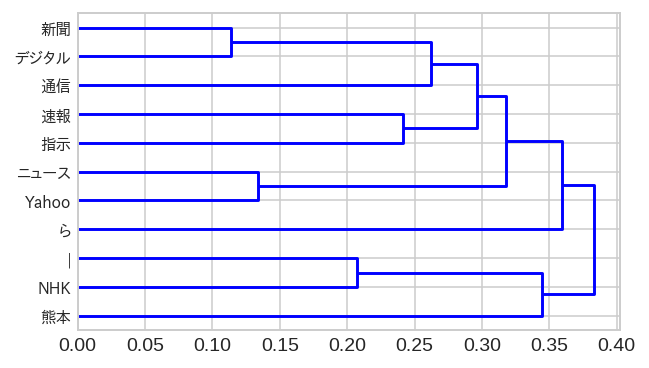

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties
%matplotlib inline
plt.style.use('seaborn-whitegrid')

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

def draw_similar_word_dendrogram(wv, word, topn=30, method='average',  metric='cosine'):
    words = [x[0] for x in sorted(wv.most_similar(word, topn=topn))]
    words.append(word)
    vectors = [wv[word] for word in words]
    df = pd.DataFrame(vectors, index=words)
    lm = linkage(pdist(df, metric=metric), method=method)

    f, ax = plt.subplots(figsize=(5,3), dpi=140)
    fp = FontProperties(fname='/usr/share/fonts/truetype/fonts-japanese-gothic.ttf', size=8)
    dendrogram(lm, labels=words, orientation='right', ax=ax, color_threshold=0.0)
    for label in plt.gca().get_yticklabels():
        label.set_fontproperties(fp)

draw_similar_word_dendrogram(wv, "ニュース", 10)